### 正则化逻辑回归

数据集：设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果，测试结果决定是否芯片要被接受或抛弃

### 2.1 数据可视化

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [201]:
data_init = pd.read_csv('./datasets/ex2data2.txt', header=None, names=['Test 1', 'Test 2', 'Accepted'])
data_init.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


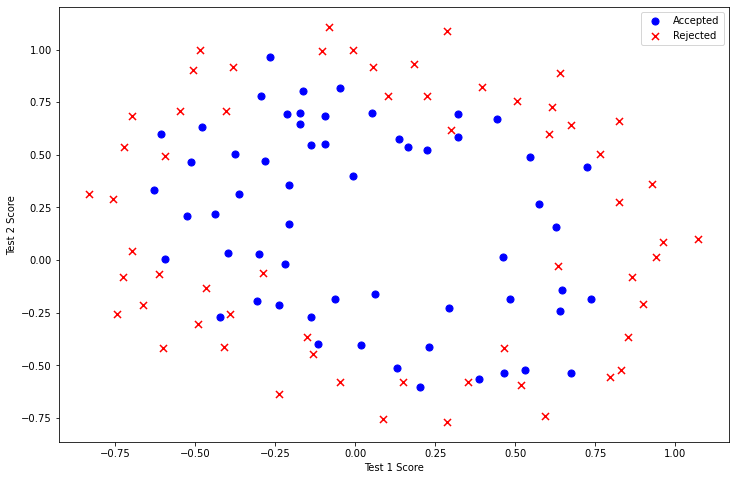

In [202]:
positive = data_init[data_init['Accepted'].isin([1])]
negative = data_init[data_init['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
plt.show()

### 2.2 特征映射

In [203]:
# 为每组x1,x2添加最高到6次幂的特征
degree = 6
data2 = data_init

x1 = data2['Test 1']
x2 = data2['Test 2']

data2.insert(3, 'Ones', 1)

In [204]:
data2

,Test 1,Test 2,Accepted,Ones
0,0.051267,0.699560,1,1
1,-0.092742,0.684940,1,1
2,-0.213710,0.692250,1,1
3,-0.375000,0.502190,1,1
4,-0.513250,0.465640,1,1
...,...,...,...,...
113,-0.720620,0.538740,0,1
114,-0.593890,0.494880,0,1
115,-0.484450,0.999270,0,1
116,-0.006336,0.999270,0,1


In [205]:
for i in range(1, degree + 1):
    for j in range(0, i + 1):
        data2['F' + str(i - j) + str(j)] = np.power(x1, i - j) * np.power(x2, j)
    
data2.drop('Test 1', axis=1, inplace=True)
data2.drop('Test 2', axis=1, inplace=True)

data2.head()

,Accepted,Ones,F10,F01,F20,F11,F02,F30,F21,F12,...,F23,F14,F05,F60,F51,F42,F33,F24,F15,F06
0,1,1,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


### 2.3 代价函数和梯度

In [206]:
# 实现sigmoid函数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [207]:
# 引入正则化项
# 实现正则化的代价函数
def costReg(theta, X, y, lr):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    print(theta.shape, X.shape, y.shape)
    
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    
    #正则化项
    reg = (lr / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    
    return np.sum(first - second) / len(X) + reg

In [208]:
# 实现正则化的梯度函数
def gradientReg(theta, X, y, lr):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
#  θ个数
    parameters = int(theta.ravel().shape[1])
    
#   初始化θ系数矩阵
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:, i])
        
        if(i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((lr / len(X)) * theta[:,i])
    
    return grad 

In [209]:
# 初始化X，y，θ
cols = data2.shape[1]
X = data2.iloc[:,1:cols]
y = data2.iloc[:,0:1]
theta2 = np.zeros(cols-1)

# 进行类型转换
X = np.array(X.values)
y = np.array(y.values)
print(theta2.shape, X.shape, y.shape)
print(X[:15])

# λ设为1
lr = 1

(28,) (118, 28) (118, 1)
[[ 1.00000000e+00  5.12670000e-02  6.99560000e-01  2.62830529e-03
   3.58643425e-02  4.89384194e-01  1.34745327e-04  1.83865725e-03
   2.50892595e-02  3.42353606e-01  6.90798869e-06  9.42624411e-05
   1.28625106e-03  1.75514423e-02  2.39496889e-01  3.54151856e-07
   4.83255257e-06  6.59422333e-05  8.99809795e-04  1.22782870e-02
   1.67542444e-01  1.81563032e-08  2.47750473e-07  3.38066048e-06
   4.61305487e-05  6.29470940e-04  8.58939846e-03  1.17205992e-01]
 [ 1.00000000e+00 -9.27420000e-02  6.84940000e-01  8.60107856e-03
  -6.35227055e-02  4.69142804e-01 -7.97681228e-04  5.89122275e-03
  -4.35092419e-02  3.21334672e-01  7.39785525e-05 -5.46363780e-04
   4.03513411e-03 -2.98012201e-02  2.20094970e-01 -6.86091891e-06
   5.06708697e-05 -3.74226408e-04  2.76382476e-03 -2.04120477e-02
   1.50751849e-01  6.36295342e-07 -4.69931780e-06  3.47065055e-05
  -2.56322636e-04  1.89305413e-03 -1.39810280e-02  1.03255971e-01]
 [ 1.00000000e+00 -2.13710000e-01  6.92250000e-01

In [210]:
# 计算初始代价
costReg(theta2, X, y, lr)

(1, 28) (118, 28) (118, 1)


0.6931471805599454

### 2.3.1 用工具库求解参数

In [211]:
# result1 = gradientReg(theta2, X, y, lr)
# result1

In [212]:
import scipy.optimize as opt
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X, y, 0.00001))
result2

(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(1, 28) (118, 28) (118, 1)
(

(array([ 2.96318856,  1.74097013,  3.08260377, -5.00556866, -3.42524887,
        -4.15147609,  0.96514517, -1.23257506, -0.99387618, -0.32760756,
        -3.63326961, -0.01891808, -1.9736207 , -1.11933   , -2.88576304,
        -0.06680262, -0.60557661,  0.05189197, -1.05777358, -1.06991349,
        -0.31384111, -2.44171348,  0.19706347, -0.92546967,  0.09687546,
        -1.1146366 , -0.66768959, -1.41930636]),
 100,
 4)

In [213]:
# 评判模型在训练集上的准确率
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [214]:
theta_min = np.matrix(result2[0])
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 98%


### 2.4 画出决策曲线

In [215]:
def hfunc2(theta, x1, x2):
    temp = theta[0][0]
    place = 0
    for i in range(1, degree+1):
        for j in range(0, i+1):
            temp+= np.power(x1, i-j) * np.power(x2, j) * theta[0][place+1]
            place+=1
    return temp

In [216]:
def find_decision_boundary(theta):
    t1 = np.linspace(-1, 1.5, 1000)
    t2 = np.linspace(-1, 1.5, 1000)

    cordinates = [(x, y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*cordinates)
    h_val = pd.DataFrame({'x1':x_cord, 'x2':y_cord})
    h_val['hval'] = hfunc2(theta, h_val['x1'], h_val['x2'])

    decision = h_val[np.abs(h_val['hval']) < 2 * 10**-3]
    return decision.x1, decision.x2

149542   -0.627127
149543   -0.627127
149590   -0.627127
150530   -0.624625
150601   -0.624625
            ...   
705427    0.764264
706358    0.766767
706359    0.766767
706412    0.766767
706413    0.766767
Name: x1, Length: 215, dtype: float64 149542    0.356356
149543    0.358859
149590    0.476476
150530    0.326326
150601    0.504004
            ...   
705427    0.068569
706358   -0.104104
706359   -0.101602
706412    0.031031
706413    0.033534
Name: x2, Length: 215, dtype: float64


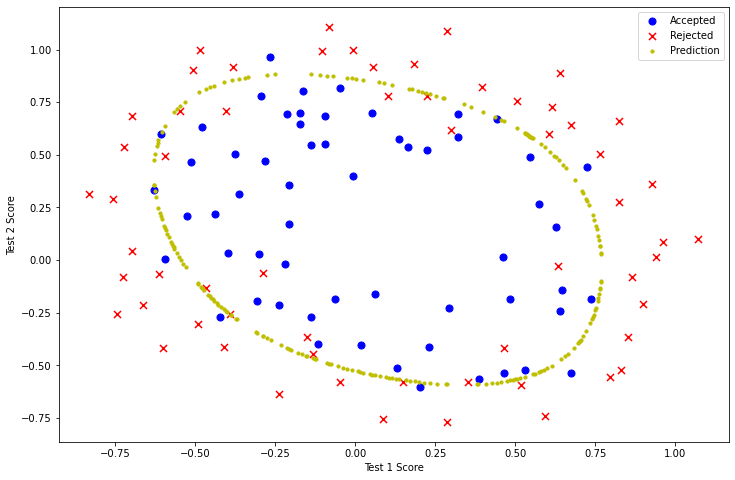

In [217]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

x, y = find_decision_boundary(result2)
print(x, y)
plt.scatter(x, y, c='y', s=10, label='Prediction')
ax.legend()
plt.show()

### 2.5 改变λ，观察决策曲线

In [218]:
lr2 = 0
result3 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X, y, lr2))
result3

(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(1, 28) (118, 28) (1, 215)
(

(array([-3.01133239e+00,  2.85756677e-03,  1.63615178e-03, -7.00978407e-03,
         1.77827964e-03, -3.72224756e-03, -1.31987922e-02, -7.14590176e-03,
        -1.11197458e-02, -8.25839224e-03,  1.95521874e-02, -3.21406745e-03,
         2.38003876e-02,  8.63953124e-04,  8.78166746e-03,  1.35214279e-02,
         9.41241928e-03,  2.25622794e-02,  1.46308122e-02,  1.19547073e-02,
         9.54597225e-03, -1.63480171e-02, -1.40465509e-03, -3.47024162e-02,
        -7.65621841e-03, -2.25391203e-02, -6.35746536e-03, -8.62516708e-03]),
 189,
 1)

Series([], Name: x1, dtype: float64) Series([], Name: x2, dtype: float64)


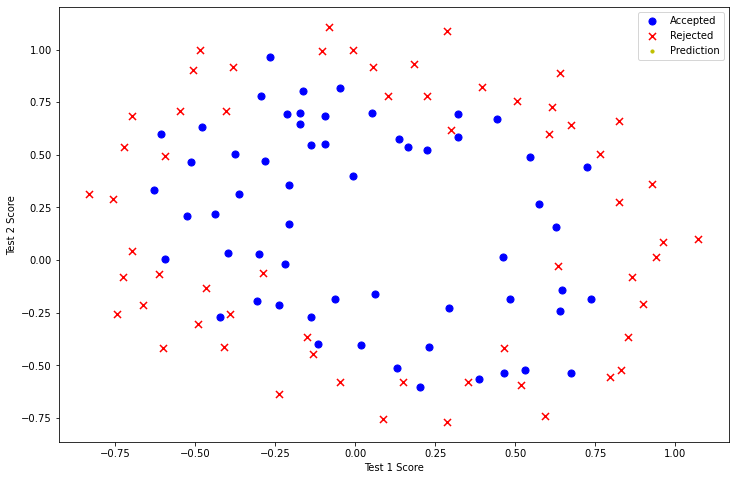

In [221]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

x, y = find_decision_boundary(result3)
print(x, y)
plt.scatter(x, y, c='y', s=10, label='Prediction')
ax.legend()
plt.show()